In [1]:
# 폴더 경로를 다룰 때 사용하는 라이브러리
import os   
import glob
import datetime
import cv2
import matplotlib.pyplot as plt # 시각화 시 사용하는 라이브러리
import numpy as np  # 수치 연산에 사용되는 선형 대수 라이브러리
from PIL import Image
import gc
# 데이터셋 정의와 모델 구축에 사용되는 Torch 기반의 라이브러리들
import torch    
import torch.nn as nn
#import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader


In [18]:
# 로컬에서 데이터셋 불러오기
origin_dir = r'C:\Users\user\Desktop\과제\인공지능\이미지 컬러라이즈\Colorimages'
resized_dir = r'C:\Users\user\Desktop\과제\인공지능\이미지 컬러라이즈\Colorimages'
gray_dir = r'C:\Users\user\Desktop\과제\인공지능\이미지 컬러라이즈\grayscale_images'
gray_dir2 = r'C:\Users\user\Desktop\과제\인공지능\이미지 컬러라이즈\testimage'

# 각 파일들의 경로를 변수에 저장.
origin_files = sorted(glob.glob(origin_dir + '*'))
resized_files = sorted(glob.glob(resized_dir + '*'))
gray_files = sorted(glob.glob(gray_dir + '*'))
gray_files2 = sorted(glob.glob(gray_dir2 + '*'))
print(gray_files2)

['C:\\Users\\user\\Desktop\\과제\\인공지능\\이미지 컬러라이즈\\testimage']


In [3]:
def read_img(file_path):
    img_arr = cv2.imread(file_path)
    return cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

In [4]:
# 이미지 정규화
# 이미지에 정규화를 진행해주면 모델이 더 빠르게 값을 구할 수 있다.
# 전체 이미지들로 부터 평균값과 표준편차를 구하는 함수
def get_mean_and_std(files):
    # global mean 구하기
    global_mean = 0
    global_var = 0

    for img in files:
        img_arr = read_img(img) / 255
        global_mean += img_arr.reshape(-1, 3).mean(axis=0)

    global_mean /= len(files)

    # global std 구하기
    for img in files:
        img_arr = read_img(img) / 255
        global_var += ((img_arr.reshape(-1, 3) - global_mean)**2).mean(axis=0)
    
    global_var /= len(files)
    global_std = np.sqrt(global_var)

    return global_mean, global_std

# 정규화된 이미지를 다시 변환시켜주는 함수.
def reNormalize(img, mean, std):
    img = img.numpy().transpose(1, 2, 0)
    img = img * std + mean
    img = img.clip(0, 1)
    return img  

In [5]:
# 데이터셋 클래스 정의
# init 함수는 흑백사진(gray)과 컬러사진(resized)를 경로를 통해서 파일명 순서대로 불러온다.
# getiem 함수는 각각의 이미지 파일을 픽셀로 저장하는 해준다. L은 단일컬러, RGB는 3채널 컬러.
# Len 함수는 파일 개수를 반환한다.
class VictorianDataset(Dataset):
    def __init__(self, root, color_transforms_=None, gray_transforms_=None):

        self.color_transforms = transforms.Compose(color_transforms_)
        self.gray_transforms = transforms.Compose(gray_transforms_)
        self.gray_files = sorted(glob.glob(os.path.join(root, gray_dir) + "/*.*"))
        self.color_files = sorted(glob.glob(os.path.join(root, resized_dir) + "/*.*"))
     
    def __getitem__(self, index):

        gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert("L")
        color_img = Image.open(self.color_files[index % len(self.color_files)]).convert("RGB")
    
        gray_img = self.gray_transforms(gray_img)
        color_img = self.color_transforms(color_img)

        return {"A": gray_img, "B": color_img}

    def __len__(self):
        return len(self.gray_files)

In [15]:

gpu = 0
color_mean = [0.52981407, 0.51292772, 0.50768467]
color_std = [0.2707057,  0.2605224,  0.26164044]
gray_mean = [0.51742526]
gray_std = [0.26162426] 


# 이미지 전처리
# 크기를 256X256 로 조절
img_height = 256
img_width = 256

batch_size = 12
test_batch_size = 1

color_transforms_ = [
    transforms.Resize(size=(img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=color_mean, std=color_std),
]

gray_transforms_ = [
    transforms.Resize(size=(img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=gray_mean, std=gray_std),
]

# 데이터 로더 
# 데이터 로더를 통해서 데이터셋에 접근한다.
train_loader = DataLoader(
    VictorianDataset(origin_dir, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    VictorianDataset(gray_dir, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=test_batch_size,
    shuffle=False
)

test2_loader = DataLoader(
    VictorianDataset(gray_dir2, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=test_batch_size,
    shuffle=False
)


In [11]:
# GAN 모델 구축
# GAN 모델은 생성 모델(Generator)과 판별 모델(Discriminator)을 경쟁적으로 학습시키는 비지도 학습 기반 생성모델이다.
# 각각의 모델은 Conv2d와 ConvTranspose2d, MaxPool2d, 정규화, 활성화함수들로 이루어져 있다.

# 생성 모델(Generator)
# 진짜 데이터와 비슷한 가짜 데이터를 만들어내도록 학습한다.
class Generator(nn.Module):
    # 네트워크 구조
    def __init__(self):
        super(Generator, self).__init__()
        """noise image + gray image"""
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )
        
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64 * 2 , 3, 1, 1),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.1)
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        self.conv1by1 = nn.Sequential(
            nn.Conv2d(64,64,1,1,0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )
        
        
        self.conv = nn.Sequential(
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )
    def forward(self, input):
        output1 = self.conv1(input)
        pool1 = self.maxpool(output1)
        output2 = self.conv2(pool1)
        output3 = self.upsample(output2) + output1
        output4 = self.conv1by1(output3)
        out = self.conv(output4)        
        return out
    
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:        
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1: 
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)
    

# 판별 모델(Discriminator)
# 진짜 데이터와 생성자가 만든 가짜 데이터를 구별하도록 학습한다.
# 이처럼 생성 모델과 판별 모델을 학습시키면서 진짜와 구분할 수 없는 가짜를 만들어내는
# 생성자를 얻을 수 있으며 적대적 학습을 하는 것이다.
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(64,128,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(128, 128, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(512, 1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace = True),
            )
        self.fc = nn.Sequential(
            nn.Linear(1024 * 8 * 8 , 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, batch_size),
            nn.Sigmoid()
        )
        
    def forward(self, input, b_size):
        output = self.main(input)
        output = self.fc(output.view(b_size,-1))
        return output

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:        
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1: 
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        


In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        """noise image + gray image"""
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=False)
        )
        
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64 * 2 , 3, 1, 1),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.1, inplace=False)
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=False)
        )
        
        self.conv1by1 = nn.Sequential(
            nn.Conv2d(64, 64, 1, 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=False)
        )
        
        self.conv = nn.Sequential(
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )
        
        self.apply(weights_init)
    
    def forward(self, input):
        output1 = self.conv1(input)
        pool1 = self.maxpool(output1)
        output2 = self.conv2(pool1)
        output3 = self.upsample(output2) + output1
        output4 = self.conv1by1(output3)
        out = self.conv(output4)        
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=False),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=False),
            
            nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=False),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=False),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=False),
            
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=False),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(1024 * 8 * 8 , 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
        self.apply(weights_init)
    
    def forward(self, input):
        output = self.main(input)
        output = self.fc(output.view(input.size(0), -1))
        return output
    
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:        
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1: 
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)    

In [9]:
print(train_loader)

In [10]:

gc.collect()
torch.cuda.empty_cache()
Gener = Generator().cuda(gpu) if torch.cuda.is_available() else Generator()
Gener.apply(weights_init)

Discri = Discriminator().cuda(gpu) if torch.cuda.is_available() else Discriminator()
Discri.apply(weights_init)

max_epoch = 10
optimizerD = torch.optim.Adam(Discri.parameters(), lr = 0.0005,betas = (0.5, 0.999))
optimizerG = torch.optim.Adam(Gener.parameters(), lr = 0.0005, betas = (0.5, 0.999))

for epoch in range(max_epoch):
    start_time = datetime.datetime.now()
    loss_D = 0.0
    for i, data in enumerate(train_loader):
        grays, color = data['A'], data['B']
        b_size = len(data['A'])
        
        ######## 생성모델(Generator) 학습 ########
        ######## Train Generator ########
        noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0,1)
        gray_noise = Variable(torch.cat([grays,noise],dim=1).cuda(gpu))
        fake_img = Gener(gray_noise)
        output = Discri(fake_img,b_size)
        g_loss = torch.mean((output-1)**2)
        

        ######## 역전파 & 생성모델 최적화 ########
        ######## Backpropagation & Optimize G ########
        Discri.zero_grad()
        Gener.zero_grad()
        g_loss.backward()
        optimizerG.step()


        ######## 판별모델(Discriminator) 학습 ########
        ######## Train Discriminator ########
        color = Variable(color.cuda(gpu))
        noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0,1)   
        gray_noise = Variable(torch.cat([grays,noise],dim=1).cuda(gpu))   


        ######## 판별모델이 컬러 이미지를 진짜(real)로 인식하도록 학습 ########
        ######## Train d to recognize color image as real ########
        output = Discri(color,b_size)
        real_loss = torch.mean((output-1)**2)
        

        ######## 판별모델이 흑백 이미지를 가짜(fake)로 인식하도록 학습 ########
        ######## Train d to recognize fake image as fake ########        
        fake_img = Gener(gray_noise)   
        output = Discri(fake_img,b_size)
        fake_loss = torch.mean(output**2)
        

        ######## 역전파 & 판별모델 최적화 ########
        ######## Backpropagation & Optimize D ########
        d_loss = real_loss + fake_loss
        Discri.zero_grad()
        Gener.zero_grad()
        d_loss.backward()
        optimizerD.step()        


        fake_img = torchvision.utils.make_grid(fake_img.data) 


    epoch_time = datetime.datetime.now() - start_time
    #if (epoch + 1) % 5 == 0:
    torch.save(Gener.state_dict(), "new1generator_%d.pth" % (epoch+1))
    
    torch.save(Discri.state_dict(), "new1discriminator_%d.pth" % (epoch+1))

    print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] ETA: %s" % (epoch+1, max_epoch, i+1, len(train_loader), d_loss.item(), g_loss.item(), epoch_time))
    plt.imshow(reNormalize(fake_img.cpu(), color_mean, color_std))
    plt.show()

     

SyntaxError: incomplete input (2432315883.py, line 1)

==================input==================


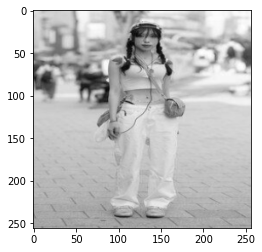

==================target==================


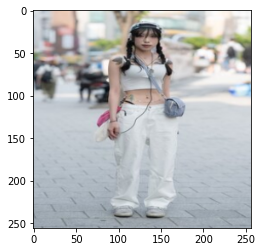

==================output==================


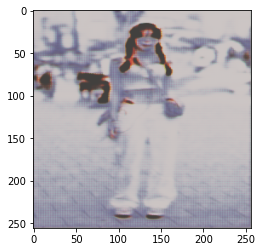

==================input==================


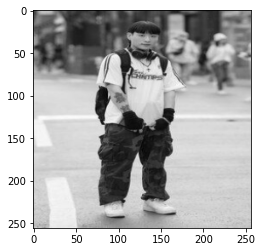

==================target==================


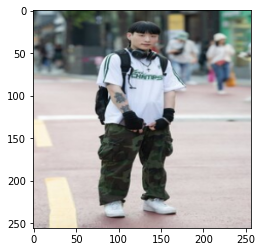

==================output==================


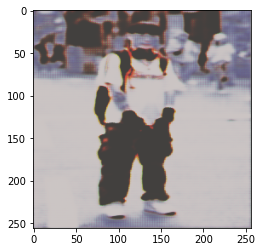

==================input==================


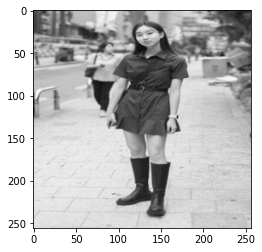

==================target==================


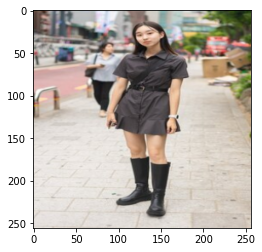

==================output==================


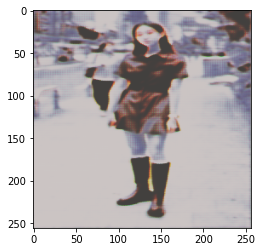

==================input==================


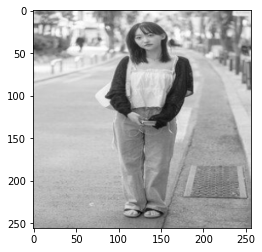

==================target==================


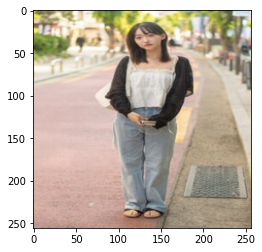

==================output==================


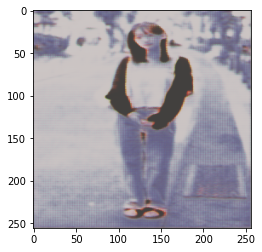

==================input==================


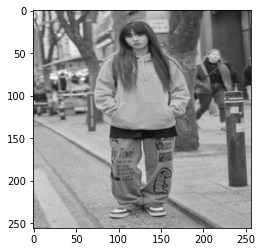

==================target==================


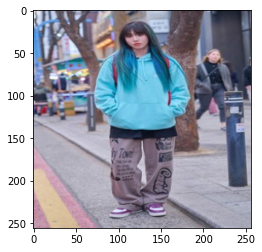

==================output==================


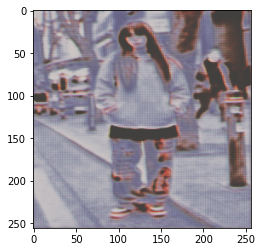

==================input==================


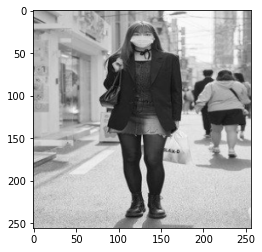

==================target==================


KeyboardInterrupt: 

In [27]:
gc.collect()
torch.cuda.empty_cache()

Gener = Generator().cuda(gpu) if torch.cuda.is_available() else Generator()
Gener.apply(weights_init)

Discri = Discriminator().cuda(gpu) if torch.cuda.is_available() else Discriminator()
Discri.apply(weights_init)

Gener.load_state_dict(torch.load("new1generator_4.pth" ))
Discri.load_state_dict(torch.load("new1discriminator_4.pth" ))      


Discri.eval()
Gener.eval()

fixed_noise = torch.randn(test_batch_size, 1, img_height, img_width).uniform_(0,1)

for i, data in enumerate(test_loader,0) :
    images, label = data['A'], data['B']

    if len(data['A']) != test_batch_size:
        continue

    grays = torch.from_numpy(np.resize(images.numpy(), (test_batch_size, 1, img_height, img_width)))    
    gray = Variable(torch.cat([grays,fixed_noise],dim = 1).cuda(gpu))
    
    output = Gener(gray)

    inputs = torchvision.utils.make_grid(grays)
    labels = torchvision.utils.make_grid(label)
    out = torchvision.utils.make_grid(output.data)

    print('==================input==================')
    plt.imshow(reNormalize(inputs.cpu(), gray_mean, gray_std))
    plt.show()
    print('==================target==================')
    plt.imshow(reNormalize(labels.cpu(), color_mean, color_std))
    plt.show()
    print('==================output==================')
    plt.imshow(reNormalize(out.cpu(), color_mean, color_std))
    plt.show()
    